In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
audio_path = '/content/drive/MyDrive/Colab Notebooks/datasets/emotion/TrainAudioFiles'
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/emotion/train.csv')

In [ ]:
df.emotion.value_counts()

neutral     2630
joy          967
surprise     640
anger        596
sadness      344
fear         328
disgust      311
Name: emotion, dtype: int64

In [3]:
df.head()

,filename,emotion
0,18777.mp3,neutral
1,24041.mp3,neutral
2,1621.mp3,joy
3,28883.mp3,neutral
4,14918.mp3,neutral


# Data Extraction

In [15]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    spec_cent = librosa.feature.spectral_centroid(y=audio, sr=sample_rate)
    spec_bw = librosa.feature.spectral_bandwidth(y=audio, sr=sample_rate)
    rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sample_rate)
    zcr = librosa.feature.zero_crossing_rate(y=audio)
    return mfccs_scaled_features,np.mean(spec_cent),np.mean(spec_bw),np.mean(rolloff),np.mean(zcr)

In [16]:
from tqdm import tqdm
#Now we iterate through every audio file and extract features 
#using Mel-Frequency Cepstral Coefficients
extracted_features=[]
cent_features=[]
bw_features=[]
roll_features=[]
zcr_features=[]
for index_num,row in tqdm(df.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_path),str(row["filename"]))
    final_class_labels=row["emotion"]
    data,cent,bw,roll,zcr=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])
    cent_features.append([cent,final_class_labels])
    bw_features.append([bw,final_class_labels])
    roll_features.append([roll,final_class_labels])
    zcr_features.append([zcr,final_class_labels])

Streaming output truncated to the last 5000 lines.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
3053it [30:35,  1.61it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
3054it [30:36,  1.61it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
3055it [30:36,  1.60it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
3057it [30:37,  1.86it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
3058it [30:38,  1.71it/s

In [17]:
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])

In [18]:
cent_features_df=pd.DataFrame(cent_features,columns=['feature','class'])

In [19]:
bw_features_df=pd.DataFrame(bw_features,columns=['feature','class'])

In [20]:
roll_features_df=pd.DataFrame(roll_features,columns=['feature','class'])

In [21]:
zcr_features_df=pd.DataFrame(zcr_features,columns=['feature','class'])

In [272]:
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [221]:
X.shape

(5816, 40)

In [273]:
X = pd.DataFrame(data=X)

In [274]:
X['40'] = cent_features_df.iloc[:,0].values
X['41'] = bw_features_df.iloc[:,0].values
X['42'] = roll_features_df.iloc[:,0].values
X['43'] = zcr_features_df.iloc[:,0].values
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43
0,-283.330444,126.994980,-36.858562,43.749313,-12.695014,8.390309,-10.315822,12.567439,-13.878289,2.707169,-19.808243,1.678325,-12.914970,-0.582696,-8.967711,1.924447,-8.773611,-1.379308,2.657079,3.920075,-2.482609,4.289345,5.700539,4.416387,-2.900037,-9.182390,-7.030731,-4.647749,1.680324,-1.666673,-4.967484,-4.499544,0.971350,5.335164,2.083691,-4.783385,-3.591913,-0.890160,1.020856,-3.158104,1767.165697,1736.040217,3467.861420,0.084970
1,-291.481476,85.954155,-31.577600,28.470999,-20.939659,6.402743,-26.454313,0.647959,-19.350630,9.184569,-15.238666,-1.453398,-13.847534,3.315650,-9.097544,-1.617307,-9.889408,3.140909,-7.998603,-2.216147,-5.582964,-1.289925,-2.167192,0.255232,-0.499061,3.777133,0.520378,1.348320,-1.177460,-2.586039,-4.342289,-1.409732,-1.081774,-0.803579,0.213091,0.264737,0.150551,0.727059,-0.628805,-1.048978,2589.622755,2076.742359,4796.409617,0.167514
2,-362.789581,123.990700,-15.951502,73.428764,-15.218165,-2.384654,-16.829374,-2.062613,-17.856745,-0.432625,-17.839840,5.935059,-11.218388,-1.525127,-4.754562,-4.365469,-10.150089,-5.024264,-8.531441,6.474306,-4.617746,-3.391284,4.462910,-3.414688,0.753211,1.100687,-3.199268,-2.347411,-0.849797,3.595180,8.396230,6.315861,9.588468,4.691628,-1.539827,-6.767616,-3.827448,-1.628554,1.926156,-4.543514,1628.308972,1780.776479,3402.963867,0.066797
3,-236.650223,117.452545,-47.395702,15.700617,-31.569071,10.442453,-15.192702,-3.809963,-14.015379,11.158181,-15.119180,0.290448,-14.120213,0.852248,-7.211405,-3.299776,-15.074923,0.183795,-5.394397,-0.878682,-3.868380,2.709947,-2.144652,-0.140477,-1.946455,0.137385,-1.075276,3.354704,2.933356,-0.808022,-1.348247,-0.244697,0.090189,2.270353,2.362933,-0.799957,-0.224312,0.632541,0.325310,-0.305637,1940.921171,1877.967890,3929.176241,0.105900
4,-395.161011,87.821884,-8.653343,25.291254,-20.770245,19.682917,-8.974556,11.303039,-12.472715,15.745876,-8.125465,3.423868,-10.801386,8.896441,-10.776619,-0.155816,-6.918583,2.025069,-9.284718,0.491287,-1.562027,-2.912856,-4.176810,2.326536,-4.064098,-2.586079,-1.923210,0.178849,-2.056087,-1.526520,2.266697,1.683096,-0.074344,0.959396,0.880367,-1.881651,-2.449817,0.003183,-0.872700,-3.012917,2653.311411,2358.615131,5381.006260,0.141830


In [275]:
X = X.values

In [276]:
X.shape

(5816, 44)

In [277]:
y=y.flatten()

In [245]:
y.shape

(5816,)

# Categorical Encoding

In [278]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

# Feature Scaling X

In [279]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Over-sampling for imbalanced dataset

In [ ]:
#As there is imbalanced dataset we will do over sampling to level the feature count.
extracted_features_df['class'].value_counts()

neutral     2630
joy          967
surprise     640
anger        596
sadness      344
fear         328
disgust      311
Name: class, dtype: int64

In [124]:
from imblearn.over_sampling import SMOTE
smote = SMOTE('minority')

In [280]:
#leveling up the classes
X,y = smote.fit_sample(X,y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [181]:
y.shape

(8135, 7)

# Build Model

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten,Conv1D,MaxPooling1D
from tensorflow.keras.optimizers import Adam,RMSprop
from sklearn import metrics
import tensorflow.keras as keras

In [304]:
num_labels=y.shape[1]
model=Sequential()
###first layer
model.add(Dense(128,input_shape=(44,)))
model.add(Activation('relu'))
###second layer
model.add(Dense(128))
model.add(Activation('relu'))
###third layer
model.add(Dense(128))
model.add(Activation('relu'))
###fourth layer
model.add(Dense(128))
model.add(Activation('relu'))
###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               5248      
_________________________________________________________________
activation (Activation)      (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2

In [305]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [306]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 
num_epochs = 100
num_batch_size = 32
start = datetime.now()
history = model.fit(X, y, batch_size=num_batch_size, epochs=num_epochs, validation_split=0.15, verbose=1)
duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
217/217 [==============================] - 1s 4ms/step - loss: 1.2837 - accuracy: 0.5599 - val_loss: 0.4061 - val_accuracy: 0.8829
Epoch 2/100
217/217 [==============================] - 1s 3ms/step - loss: 1.1890 - accuracy: 0.5699 - val_loss: 0.3244 - val_accuracy: 0.8837
Epoch 3/100
217/217 [==============================] - 1s 3ms/step - loss: 1.1198 - accuracy: 0.5869 - val_loss: 0.2892 - val_accuracy: 0.9509
Epoch 4/100
217/217 [==============================] - 1s 3ms/step - loss: 1.0404 - accuracy: 0.6076 - val_loss: 0.2599 - val_accuracy: 0.9476
Epoch 5/100
217/217 [==============================] - 1s 3ms/step - loss: 0.9729 - accuracy: 0.6277 - val_loss: 0.1057 - val_accuracy: 0.9730
Epoch 6/100
217/217 [==============================] - 1s 3ms/step - loss: 0.9081 - accuracy: 0.6504 - val_loss: 0.1561 - val_accuracy: 0.9844
Epoch 7/100
217/217 [==============================] - 1s 3ms/step - loss: 0.8292 - accuracy: 0.6877 - val_loss: 0.1233 - val_accuracy: 0.9885

# Plot Accuracy and loss

Text(0.5, 1.0, 'Training and validation loss')

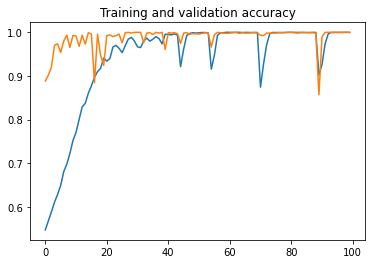

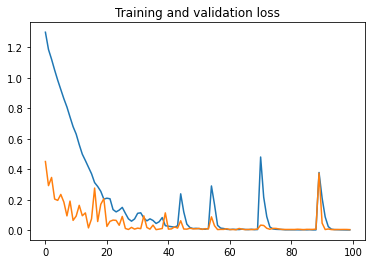

In [215]:
import matplotlib.pyplot as plt
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]
epochs   = range(len(acc)) # Get number of epochs
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

# Test Data

In [61]:
audio_path_test = '/content/drive/MyDrive/Colab Notebooks/datasets/emotion/TestAudioFiles'
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/emotion/test.csv')

In [62]:
def features_extractor_test(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    #chrom = librosa.feature.chroma_stft(audio,sr=sample_rate,hop_length=512)
    #chrom_scaled = np.mean(chrom.T,axis=0)
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    spec_cent = librosa.feature.spectral_centroid(y=audio, sr=sample_rate)
    spec_bw = librosa.feature.spectral_bandwidth(y=audio, sr=sample_rate)
    rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sample_rate)
    zcr = librosa.feature.zero_crossing_rate(y=audio)
    return mfccs_scaled_features,np.mean(spec_cent),np.mean(spec_bw),np.mean(rolloff),np.mean(zcr)

In [ ]:
from tqdm import tqdm
#Now we iterate through every audio file and extract features 
#using Mel-Frequency Cepstral Coefficients
extracted_features_test=[]
cent_features=[]
bw_features=[]
roll_features=[]
zcr_features=[]
for index_num,row in tqdm(df_test.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_path_test),str(row["filename"]))
    data,cent,bw,roll,zcr=features_extractor_test(file_name)
    extracted_features_test.append([data])
    cent_features.append([cent])
    bw_features.append([bw])
    roll_features.append([roll])
    zcr_features.append([zcr])

In [307]:
extracted_features_df_test=pd.DataFrame(extracted_features_test,columns=['feature'])
test=np.array(extracted_features_df_test['feature'].tolist())

In [308]:
test = pd.DataFrame(data=test)

In [68]:
cent_features_df_test=pd.DataFrame(cent_features,columns=['feature'])
bw_features_df_test=pd.DataFrame(bw_features,columns=['feature'])
roll_features_df_test=pd.DataFrame(roll_features,columns=['feature'])
zcr_features_df_test=pd.DataFrame(zcr_features,columns=['feature'])
final_features_df_test = pd.DataFrame(data=[cent_features_df_test.iloc[:,0].values,bw_features_df_test.iloc[:,0].values,roll_features_df_test.iloc[:,0].values,zcr_features_df_test.iloc[:,0].values])

In [70]:
final_features_df_test=final_features_df_test.T

In [256]:
final_features_df_test

,0,1,2,3
0,1853.926988,1749.424677,3557.644043,0.097298
1,2107.889680,1660.635264,3669.276376,0.134694
2,1852.312749,1656.119817,3363.146330,0.109709
3,2191.238891,2054.011713,4314.566040,0.121596
4,1319.220532,1604.566861,2910.399367,0.061866
...,...,...,...,...
2487,2883.419906,2147.053976,5195.119310,0.214409
2488,2046.588122,1887.119800,3817.495243,0.116573
2489,2216.583137,1844.083707,3956.320880,0.134293
2490,1547.186018,1679.157136,3303.369141,0.075434


In [309]:
test['40'] = cent_features_df_test.iloc[:,0].values
test['41'] = bw_features_df_test.iloc[:,0].values
test['42'] = roll_features_df_test.iloc[:,0].values
test['43'] = zcr_features_df_test.iloc[:,0].values
test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43
0,-360.310822,117.225731,-47.020271,27.272320,-20.225014,6.399932,-8.797650,3.995431,-10.299968,4.129894,-13.833005,-3.980232,-7.381487,3.474222,5.986731,1.860489,1.385682,4.782443,0.634623,-1.667395,0.577988,-0.542852,-6.664360,-4.452849,-3.882575,0.901826,2.352417,1.016292,5.525303,1.264986,-4.274261,-1.189946,1.209545,2.036772,2.363331,-0.396534,0.594497,-0.558552,-1.096439,-0.205507,1853.926988,1749.424677,3557.644043,0.097298
1,-346.760773,119.772278,-65.248001,28.385748,-17.256676,1.414778,-19.303654,-0.006129,-4.838943,4.835452,-16.498344,12.547888,-8.775145,11.379468,-0.904659,-2.017423,-6.308467,-2.181329,-4.148189,-5.050063,-5.384000,-1.342580,-7.869848,1.716545,-2.423089,-2.918014,-3.963760,-1.422047,0.560439,0.671387,-2.383530,7.322190,2.742337,0.642733,-0.881403,-0.605303,2.004715,1.313815,0.616276,-1.711690,2107.889680,1660.635264,3669.276376,0.134694
2,-243.601807,127.731903,-64.965485,25.595831,-21.645216,1.641017,-25.800625,-3.212504,-19.842356,13.584959,-20.353590,-1.236349,-9.163232,5.872550,-1.217163,2.933704,-9.481050,0.406360,-8.714175,-3.571723,1.933326,-4.054011,-4.838553,-2.644065,-8.619534,-8.262488,-6.547913,-7.965904,-8.768993,-4.172144,-5.728040,-8.026464,-6.671174,-2.071067,-1.687181,-4.454697,1.241054,-0.175630,-1.472735,-2.150387,1852.312749,1656.119817,3363.146330,0.109709
3,-352.042114,114.847565,-29.467285,29.095842,-19.170322,14.442498,-15.056951,10.540667,-13.710228,8.913204,-7.866338,9.865336,-7.242176,5.642800,-3.217012,5.899613,-3.313632,2.275721,-3.259466,0.517869,-2.816062,0.030498,-3.986774,-1.294296,-4.367609,-1.524812,-2.930416,-2.981319,-2.975466,-4.409580,-1.574091,-2.890487,-3.147945,-3.276536,-2.336376,-3.440485,-1.472845,-1.562896,0.256759,0.085878,2191.238891,2054.011713,4314.566040,0.121596
4,-402.002899,131.972260,-3.767405,57.126369,-5.330755,14.938948,-10.694655,-0.575818,-2.828084,-2.775017,5.426503,-11.814539,6.172842,-6.474564,-1.124049,-2.844613,-4.112265,0.511748,-2.982589,0.428808,-5.600098,1.815831,-1.625146,0.119953,3.307432,-0.293566,-0.053331,-0.411368,0.906042,-1.957615,1.770211,-0.503118,-0.532595,1.169265,-0.273719,2.817329,1.192993,0.105612,-0.235465,0.841233,1319.220532,1604.566861,2910.399367,0.061866


In [310]:
test=test.values

In [311]:
test = scaler.fit_transform(test)

In [312]:
predicted_label = model.predict_classes(test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [313]:
classess = labelencoder.inverse_transform(predicted_label)

In [314]:
df_test['emotion'] = classess

In [315]:
df_test

,filename,emotion
0,26199.mp3,neutral
1,692.mp3,neutral
2,16821.mp3,neutral
3,1608.mp3,neutral
4,47947.wav,disgust
...,...,...
2487,16692.mp3,neutral
2488,29505.mp3,neutral
2489,5807.mp3,anger
2490,43982.wav,fear


In [316]:
df_test.to_csv('submit.csv',index=False)